In [2]:
# CNN transfer learning method with different architectures model training and evaluation
# this notebook largely are from online resources

In [9]:
# we only use one single architecture ---Resnet50 due to time and computational constraints
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
import os
import cv2
from tqdm import tqdm
import gc
warnings.filterwarnings('ignore')

In [11]:
# set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

print(" Starting CNN Transfer Learning")
print("=" * 60)
# record start time
total_start_time = time.time()

# load data
loading_start_time = time.time()
train_metadata = pd.read_csv("/Users/xingzhidu/Desktop/ML/ML A2/dataset/train/train_metadata.csv")
test_metadata = pd.read_csv("/Users/xingzhidu/Desktop/ML/ML A2/dataset/test/test_metadata.csv")

print(f" Original training data: {train_metadata.shape}")
print(f" Test data: {test_metadata.shape}")

# just to a sample subset for faster training if later training too long
# we can go back here to change to sample size, None means the whole dataset
SAMPLE_SIZE = None 
if SAMPLE_SIZE and SAMPLE_SIZE < len(train_metadata):
    # stratified sampling to maintain class distribution
    train_metadata = train_metadata.groupby('ClassId').apply(
        lambda x: x.sample(min(len(x), SAMPLE_SIZE // 43), random_state=RANDOM_SEED)
    ).reset_index(drop=True)
    print(f"⚡ Sampled training data: {train_metadata.shape}")

# define optimized parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 64 
N_CLASSES = 43

def preprocess_image_fast(image_path, target_size=IMG_SIZE):
    """pptimized image preprocessing"""
    img = cv2.imread(image_path)
    if img is None:
        return np.zeros((*target_size, 3), dtype=np.float32)
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    img = img.astype(np.float32) / 255.0
    return img

def load_images_batch(metadata_df, base_path, batch_size=1000):
    """load images in batches to manage memory"""
    images = []
    labels = []
    
    print(f"   Loading {len(metadata_df)} images in batches...")
    
    for i in tqdm(range(0, len(metadata_df), batch_size), desc="   Loading batches"):
        batch_df = metadata_df.iloc[i:i+batch_size]
        batch_images = []
        batch_labels = []
        
        for _, row in batch_df.iterrows():
            img_path = os.path.join(base_path, row['image_path'])
            img = preprocess_image_fast(img_path)
            batch_images.append(img)
            
            if 'ClassId' in row:
                batch_labels.append(row['ClassId'])
        
        images.extend(batch_images)
        labels.extend(batch_labels)
    
    images = np.array(images)
    if labels:
        labels = np.array(labels)
        labels_categorical = to_categorical(labels, num_classes=N_CLASSES)
        return images, labels, labels_categorical
    else:
        return images, None, None

# load training data
train_base_path = "/Users/xingzhidu/Desktop/ML/ML A2/dataset/train"
X_train_images, y_train_raw, y_train_categorical = load_images_batch(
    train_metadata, train_base_path
)

print(f" Training images loaded: {X_train_images.shape}")
print(f" Training labels: {y_train_raw.shape}")

loading_time = time.time() - loading_start_time
print(f" Data loading completed in {loading_time:.1f}s")

# Create optimized ResNet50 model
model_creation_start_time = time.time()

def create_efficient_model(input_shape=(224, 224, 3), num_classes=43):
    """create efficient ResNet50 transfer learning model"""
    
    # load pretrained ResNet50 without top
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # add efficient classification head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)  # use a smaller dense layer
    x = Dropout(0.3)(x)  # Reduced dropout
    predictions = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # initially freeze base model
    base_model.trainable = False
    
    print(f"    Model created - Total parameters: {model.count_params():,}")
    print(f"    Trainable parameters: {sum([tf.keras.backend.count_params(w) for w in model.trainable_weights]):,}")
    
    return model, base_model

# create model
model, base_model = create_efficient_model()

model_creation_time = time.time() - model_creation_start_time
print(f" Model creation completed in {model_creation_time:.1f}s")

# training with simple train/validation split instead of CV
X_train, X_val, y_train, y_val, y_train_cat, y_val_cat = train_test_split(
    X_train_images, y_train_raw, y_train_categorical,
    test_size=0.2, stratify=y_train_raw, random_state=RANDOM_SEED
)

print(f" Train set: {X_train.shape}")
print(f" Validation set: {X_val.shape}")

def compile_and_train_efficient(model, base_model, X_train, y_train_cat, X_val, y_val_cat):
    """training with reduced epochs"""
    
    print("\n Phase 1: Training classification head (frozen base)")
    
    # compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # callbacks for efficiency
    callbacks = [
        EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, verbose=1)
    ]
    
    # reduced epochs
    phase1_start = time.time()
    history1 = model.fit(
        X_train, y_train_cat,
        batch_size=BATCH_SIZE,
        epochs=10,  # Reduced from 15
        validation_data=(X_val, y_val_cat),
        callbacks=callbacks,
        verbose=1
    )
    phase1_time = time.time() - phase1_start
    print(f" Phase 1 completed in {phase1_time:.1f}s")
    
    print("\n Phase 2: Fine-tuning (unfrozen base)")
    
    # unfreeze base model
    base_model.trainable = True
    
    # fine-tune from halfway point
    fine_tune_at = len(base_model.layers) // 2
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False
    
    # recompile with lower learning rate
    model.compile(
        optimizer=Adam(learning_rate=0.0001),  # Lower learning rate
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # fine-tuning with fewer epochs
    phase2_start = time.time()
    history2 = model.fit(
        X_train, y_train_cat,
        batch_size=BATCH_SIZE,
        epochs=8,  # Reduced from 10
        validation_data=(X_val, y_val_cat),
        callbacks=[EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True, verbose=1)],
        verbose=1
    )
    phase2_time = time.time() - phase2_start
    print(f" Phase 2 completed in {phase2_time:.1f}s")
    
    # combine histories
    combined_history = {
        'loss': history1.history['loss'] + history2.history['loss'],
        'accuracy': history1.history['accuracy'] + history2.history['accuracy'],
        'val_loss': history1.history['val_loss'] + history2.history['val_loss'],
        'val_accuracy': history1.history['val_accuracy'] + history2.history['val_accuracy']
    }
    
    return combined_history, phase1_time + phase2_time

 Starting CNN Transfer Learning
 Original training data: (5488, 5)
 Test data: (2353, 3)
   Loading 5488 images in batches...


   Loading batches: 100%|█████████████████████████| 6/6 [00:01<00:00,  4.20it/s]


 Training images loaded: (5488, 224, 224, 3)
 Training labels: (5488,)
 Data loading completed in 2.9s
    Model created - Total parameters: 24,123,307
    Trainable parameters: 535,595
 Model creation completed in 0.4s
 Train set: (4390, 224, 224, 3)
 Validation set: (1098, 224, 224, 3)



 Training ResNet50 model...

 Phase 1: Training classification head (frozen base)
Epoch 1/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.0534 - loss: 3.6683 - val_accuracy: 0.0774 - val_loss: 3.4652 - learning_rate: 0.0010
Epoch 2/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.0731 - loss: 3.4747 - val_accuracy: 0.0565 - val_loss: 3.4314 - learning_rate: 0.0010
Epoch 3/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.0755 - loss: 3.4410 - val_accuracy: 0.0911 - val_loss: 3.3956 - learning_rate: 0.0010
Epoch 4/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.0765 - loss: 3.4086 - val_accuracy: 0.0902 - val_loss: 3.3717 - learning_rate: 0.0010
Epoch 5/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 821ms/step - accuracy: 0.0820 - loss: 3.3771
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
69/69 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.0821 - loss: 3.3771 - val_accuracy: 0.0911 - val_loss: 3.3556 - learning_rate: 0.0010
Epoch 6/10
69/69

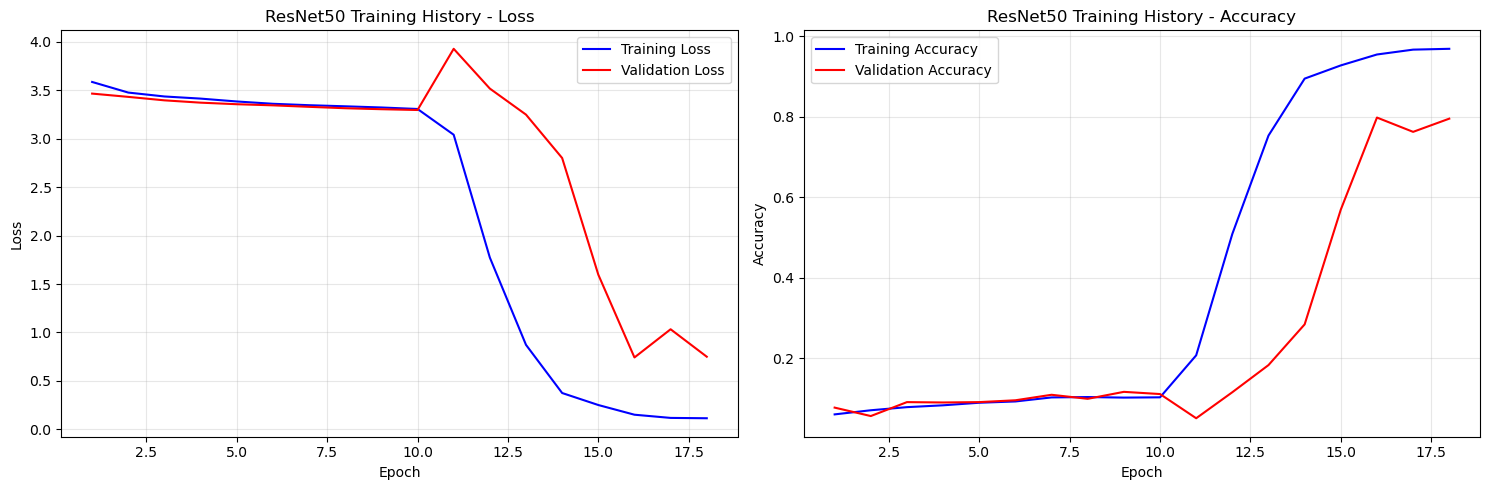


🔍 Quick Performance Analysis:
   📊 Validation Accuracy: 0.7978
   📈 Best Val Accuracy: 0.7978
   📉 Final Training Loss: 0.1144
   📉 Final Validation Loss: 0.7496


In [12]:
# train and evaluate
print("\n Training ResNet50 model...")
print("=" * 60)

training_start_time = time.time()

# train model
history, training_duration = compile_and_train_efficient(
    model, base_model, X_train, y_train_cat, X_val, y_val_cat
)

# evaluate on validation set
print("\n Evaluating model...")
val_predictions_probs = model.predict(X_val, batch_size=BATCH_SIZE, verbose=1)
val_predictions = np.argmax(val_predictions_probs, axis=1)

# calculate metrics
val_accuracy = accuracy_score(y_val, val_predictions)
val_report = classification_report(y_val, val_predictions, output_dict=True, zero_division=0)

training_time = time.time() - training_start_time
print(f"\n Training completed in {training_time:.1f}s")
print(f" Final Validation Accuracy: {val_accuracy:.4f}")

# create visualisation for analysis
# plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# training curves
epochs = range(1, len(history['loss']) + 1)
ax1.plot(epochs, history['loss'], 'b-', label='Training Loss')
ax1.plot(epochs, history['val_loss'], 'r-', label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('ResNet50 Training History - Loss')
ax1.legend()
ax1.grid(alpha=0.3)

ax2.plot(epochs, history['accuracy'], 'b-', label='Training Accuracy')
ax2.plot(epochs, history['val_accuracy'], 'r-', label='Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('ResNet50 Training History - Accuracy')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('efficient_cnn_training.png', dpi=300, bbox_inches='tight')
plt.show()

# quick performance analysis
print(f"\n Quick Performance Analysis:")
print(f" Validation Accuracy: {val_accuracy:.4f}")
print(f" Best Val Accuracy: {max(history['val_accuracy']):.4f}")
print(f" Final Training Loss: {history['loss'][-1]:.4f}")
print(f" Final Validation Loss: {history['val_loss'][-1]:.4f}")

In [13]:
# to do the test predictions
# load test images
print("   Loading test images...")
test_base_path = "/Users/xingzhidu/Desktop/ML/ML A2/dataset/test"
X_test_images, _, _ = load_images_batch(test_metadata, test_base_path)

print(f"    Test images loaded: {X_test_images.shape}")

# make predictions
test_predictions_probs = model.predict(X_test_images, batch_size=BATCH_SIZE, verbose=1)
test_predictions = np.argmax(test_predictions_probs, axis=1)

# create submission
submission_df = pd.DataFrame({
    'id': test_metadata['id'],
    'ClassId': test_predictions
})

filename = 'cnn_submission_efficient_resnet50.csv'
submission_df.to_csv(filename, index=False)

   Loading test images...
   Loading 2353 images in batches...


   Loading batches: 100%|█████████████████████████| 3/3 [00:00<00:00,  5.45it/s]


    Test images loaded: (2353, 224, 224, 3)
37/37 ━━━━━━━━━━━━━━━━━━━━ 31s 826ms/step
